### Initialize parameters:
1. N = total number of data points
2. d = dimensions of data
3. k = number of clusters
4. maxIter = maximum number of iterations to run inside kmeans
4. reps = minimum number of times to repeat kmeans over X

In [204]:
N=1000
d=3
k=5
maxIter=10000
reps=10

### Create sample data set with clusters using scikit learn:

In [205]:
import numpy as np
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=N, 
                  n_features=d, 
                  centers=k)

np.concatenate(( X[0:5,:], np.reshape(y[0:5],(-1,1)) ) ,axis=1)

array([[-5.27676676,  2.83036849, -3.37113599,  3.        ],
       [ 2.34326604, -0.93644174, -9.09284624,  2.        ],
       [-1.73176716,  7.94144164, -9.12085872,  1.        ],
       [-3.13026886,  1.21591186, -5.22034687,  3.        ],
       [-8.92787017, 10.06091302,  0.26198838,  0.        ]])

### Visualize original data with true clusters

Text(0.5, 0.92, 'Original Data with True Clusters Shown')

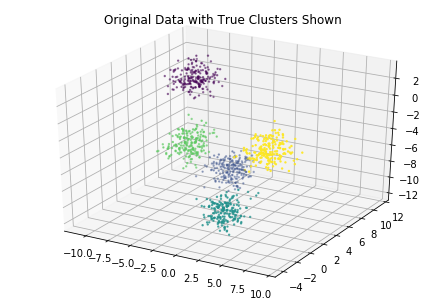

In [206]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# for 3D data
if d==3:  
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, s=2)
# for 2D data
else:
    fig, ax = plt.subplots()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=2)
ax.set_title("Original Data with True Clusters Shown")

### Re-usable plotting function for 2D and 3D data

In [207]:
## plot dataset and centroids, for 2d and 3d data
def plot_clusters(X, centroids, cluster_labels, title, d):
    # color each cluster differently, using cluster indices as labels
    label_color_map = {  0:'c',
                         1:'y',
                         2:'r',
                         3:'b',
                         4:'g',
                         5:'m',  
                         6:'purple',
                         7:'pink',
                         8:'olive',
                         9:'orange',
                         10:'lime',
                         11:'gray',
                         12:'brown'
                      }
    # retreive color label for each data point from map above, using assigned cluster lebels
    label_color = [label_color_map[l] for l in cluster_labels]
    # create scatter plot of data and centroids
    if d==3:
        fig = plt.figure()
        ax = Axes3D(fig)
        ax.set_zlabel('Feature 3')
        ax.scatter(X[:,0], X[:,1], X[:,2], color=label_color, s=1)
        ax.scatter(centroids[:,0], centroids[:,1], centroids[:,2], color='k', marker="*", s=300)
    else:
        fig, ax = plt.subplots()
        ax.scatter(X[:,0], X[:,1], color=label_color, s=1)
        ax.scatter(centroids[:,0], centroids[:,1], color='k', marker="*", s=300)
        
    ax.set_title(title)
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')

# 1. Use Scikit Learn KMeans to cluster data

In [208]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=k,
                init='k-means++',
                max_iter=maxIter,
                n_init=reps)
kmeans = kmeans.fit(X)
sk_labels = kmeans.predict(X)
sk_centroids = kmeans.cluster_centers_
sk_iters = kmeans.n_iter_   
# sum of squared distances of data points from closest centroids
sk_sse = kmeans.inertia_

### Visualize results from sklearn kmeans

Iterations:  2
SSE:  2926.53622940331
Centroids: 
 [[-4.63555543  2.79185991 -4.40616526]
 [ 6.70266466 -0.92072007 -1.09815897]
 [-8.40927756  8.47078163  0.10402544]
 [-3.25948179  7.12379925 -9.40025165]
 [ 2.21960819 -1.09779483 -9.19117766]]


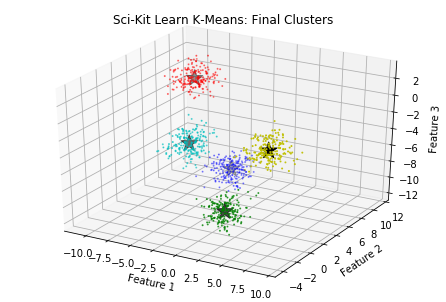

In [209]:
plot_clusters(X, sk_centroids, sk_labels, 'Sci-Kit Learn K-Means: Final Clusters', d)

print("Iterations: ", sk_iters)
print("SSE: ", sk_sse)
print("Centroids: \n", sk_centroids)

# 2. Implement K-Means from Scratch

### (i) Define function for K-Means++ Algorithm to seed initial centroids

In [210]:
import random

# parameters: X (data set), k (number of clusters)
# returns: centroids (array of initial cluster centers)
def kmeans_pp(X, k):
    # randomly choose first centroid from X
    rand_int = random.randint(0, np.size(X,0)-1)
    centroids = np.array([X[rand_int]])
    # remove already selected centroid from dataset X
    X = np.delete(X,rand_int,axis=0)
    # for each remaining centroid, do
    for c in range(1, k):
        # get min L2 distance (squared) from each data point in X to nearest centroid (thats already chosen)
        Dx = np.array([min([np.linalg.norm(x-c)**2 for c in centroids]) for x in X])
        # get weighted probability distribution of each data point wrt Dx^2
        probs = Dx / np.sum(Dx)
        # get cumulative probability of probs 
        cumprobs = np.cumsum(probs)
        # pick data point from X to be next center at random using weighted probs dist wrt Dx^2
        r = random.random()
        ind = np.where(cumprobs >= r)[0][0]
        centroids = np.append(centroids, [X[ind]], axis=0)
        X = np.delete(X,ind,axis=0)
    return centroids

### (ii) Define K-Means function with repetition

In [211]:
# performs kmeans clustering on X once
# parameters: Nxp dataset:X, number of clusters:k, maximum iterations to run:maxIter
# returns: seeds (initial centroids from k-means++), centroids (kxp array of final cluster centers)...
#          iters (total number of iterations run), cluster_labels (Nx1 array of assignments for each data point)
#          sse (sum of squared errors = squared distance of each data point to closest centroid)

def k_means_fit(X, k, maxIter):
    # initialize k centroids using kmeans++
    seeds = kmeans_pp(X, k)
    centroids = seeds
    iters=0
    stopLoop = False
    
    # keep iterating until max iterations reached or no change in centroid updates
    while (iters < maxIter) and (not stopLoop):
        iters = iters + 1
        # stores sum of all data points belonging to each cluster
        cluster_sum = np.zeros(centroids.shape, dtype='float64')
        # stores cluster assignments for each data point in X
        cluster_labels = np.zeros(np.size(X,0), dtype='int64')
        
        # loop through entire dataset X
        for i,data_point in enumerate(X):
            # calculate Euclidean L2 distance of data point from each of the k centroids
            distances = np.linalg.norm(data_point - centroids, axis=1)
            # find index of closest centroid to current data point
            min_index = np.argmin(distances)
            # save min_index assignment for each data point
            cluster_labels[i] = min_index
            # update sum of all data points belonging to this cluster
            cluster_sum[min_index] += data_point
        
        # get total number of data points for each cluster
        cluster_count = np.bincount(cluster_labels, minlength=k)
        # new centroids are means of sum/count for each cluster (add new axis to count vector to allow broadcasting)
        new_centroids = cluster_sum / cluster_count[:,None]
        # calculate the L2 distance between new and old centroids
        L2_distances = np.linalg.norm(centroids - new_centroids, axis=1)
        # update centroids
        centroids = new_centroids
        
        # sum of squared errors = squared distance of each data point from closest centroid
        sse=0
        for i,xi in enumerate(X):
            cluster = centroids[cluster_labels[i]]
            sse += np.linalg.norm(xi-cluster)**2
        
        # if all L2 distance is <= 0.001 (no centroids change), stop iterating
        if np.any(L2_distances <= 0.001):
            stopLoop = True
    
    return seeds, centroids, iters, cluster_labels, sse

# performs kmeans on X 'reps' many times and returns cluster set with lowest SSE
# parameters: Nxp dataset:X, number of clusters:k, maximum iterations to run:maxIter, number of times to repeat kmeans:reps
# returns: seeds (initial centroids from k-means++), centroids (kxp array of final cluster centers)...
#          iters (total number of iterations run), cluster_labels (Nx1 array of assignments for each data point)
#          sse (sum of squared errors = squared distance of each data point to closest centroid)
def k_means(X, k, maxIter, reps):
    min_sse=float("inf")
    for i in range(0,reps):
        i_seeds, i_centroids, i_iters, i_cluster_labels, sse = k_means_fit(X, k, maxIter)
        if (sse < min_sse):
            min_sse = sse
            seeds = i_seeds
            centroids = i_centroids
            iters = i_iters
            cluster_labels = i_cluster_labels
    
    return seeds, centroids, iters, cluster_labels, min_sse

### (iii) Fit data using K-Means (from scratch) with 10 repetitions to get best SSE

In [212]:
seeds, centroids, iters, cluster_labels, sse = k_means(X, k, maxIter, reps)

### (iv) Visualize data set with initial seeds

Text(0.5, 0.92, 'Original Data with Initial Seeds')

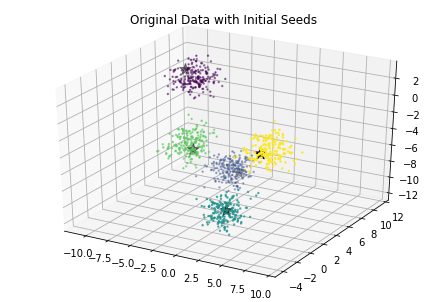

In [213]:
# for 3D data
if d==3:  
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, s=2)
    ax.scatter(seeds[:, 0], seeds[:, 1], seeds[:, 2], c='k', marker="*", s=150)
# for 2D data
else:
    fig, ax = plt.subplots()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=2)
    ax.scatter(seeds[:, 0], seeds[:, 1], c='k', marker="*", s=150)
ax.set_title("Original Data with Initial Seeds")


### Visualize results of k-means (from scratch) clustering

Iterations:  2
SSE:  2926.5362294033084
Centroids: 
 [[ 2.21960819 -1.09779483 -9.19117766]
 [-3.25948179  7.12379925 -9.40025165]
 [-4.63555543  2.79185991 -4.40616526]
 [ 6.70266466 -0.92072007 -1.09815897]
 [-8.40927756  8.47078163  0.10402544]]


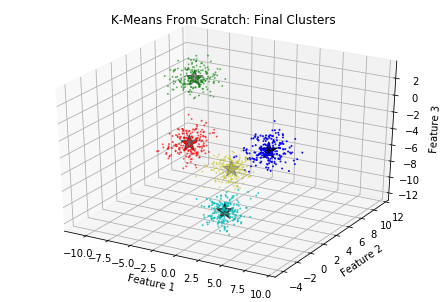

In [214]:
plot_clusters(X, centroids, cluster_labels, 'K-Means From Scratch: Final Clusters', d)

print("Iterations: ", iters)
print("SSE: ", sse)
print("Centroids: \n", centroids)